### Importing Libraries

In [1]:
import sys
import os
import math
import time
import pandas as pd
from glob import iglob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Lambda, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import SGD
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix

### Importing dataset

In [2]:
benign=pd.read_csv("Doorbell/benign_traffic.csv")
x_train, x_opt, x_test = np.split(benign.sample(frac=1, random_state=20), [int(1/3*len(benign)), int(2/3*len(benign))])

df_mirai = pd.concat((pd.read_csv(f) for f in iglob('Doorbell/mirai/*.csv', recursive=False)), ignore_index=True)
df_gafgyt = pd.concat((pd.read_csv(f) for f in iglob('Doorbell/gafgyt/*.csv', recursive=False)), ignore_index=True)

In [3]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 'malicious'

df_ben = x_train.copy()
df_ben['class'] = 'benign'

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=20))

### Plotting samples of benign and malicious data

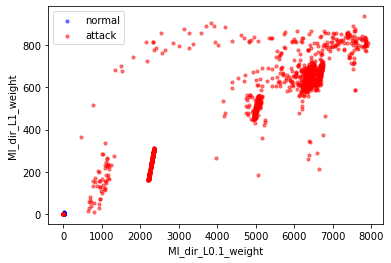

In [4]:
plot_n = 2000
atk = df_attack.sample(n=plot_n, random_state=76)
nrm = x_train.sample(n=plot_n, random_state=42)

fig, ax1 = plt.subplots()

ax1.scatter(nrm['MI_dir_L0.1_weight'],nrm['MI_dir_L1_weight'],10,c='blue', label='normal',alpha=0.5)
ax1.scatter(atk['MI_dir_L0.1_weight'],atk['MI_dir_L1_weight'],10,c='red',label='attack',alpha=0.5)

plt.xlabel('MI_dir_L0.1_weight')
plt.ylabel('MI_dir_L1_weight')

plt.legend()
plt.show()

In [5]:
classes = ['benign','malicious']
scored = []
indices = {}
shps = {}

#classifying benign as true and attack as false
for cl in classes:
    indices[cl] = df_ben['class'] == cl    
    shps[cl] =  df_ben[indices[cl]].shape[0]
        
for col in df_ben.columns:
    if col == 'class':
        continue
    num = 0
    den = 0
    m = df_ben[col].mean()
    
    for cl in classes:
        num += (shps[cl] / df_ben.shape[0]) * (m - df_ben[indices[cl]][col].mean())**2
        den += (shps[cl] / df_ben.shape[0]) * df_ben[indices[cl]][col].var()
    score = {'feature': col, 'score': num / den}
    scored.append(score)
    #print(score)
scored.sort(key=lambda x: x['score'], reverse=True)
scored[:5]

[{'feature': 'MI_dir_L1_weight', 'score': 1.2812281390780917},
 {'feature': 'H_L1_weight', 'score': 1.2812280965525344},
 {'feature': 'MI_dir_L3_weight', 'score': 1.2804935428770359},
 {'feature': 'H_L3_weight', 'score': 1.280493542758028},
 {'feature': 'MI_dir_L0.1_weight', 'score': 1.279751003162228}]

### Predicting Anomaly

In [6]:
class AnomalyModel:
    #initialize model
    def __init__(self, model, threshold, scaler):
        self.model = model
        self.threshold = threshold
        self.scaler = scaler

    #predict the outcome using treshold
    def predict(self, x):
        x_pred = self.model.predict(x)
        mse = np.mean(np.power(x - x_pred, 2), axis=1)
        y_pred = mse > self.threshold
        return y_pred.astype(int)
    
    #scale the classes
    def scale_predict_classes(self, x):
        x = self.scaler.transform(x)
        y_pred = self.predict(x)
        classes_arr = []
        for e in y_pred:
            el = [0,0]
            el[e] = 1
            classes_arr.append(el)
        print(classes_arr)

        return np.array(classes_arr)

### Model creation - Deep autoencoder

In [7]:
def deep_model(input_dim):
    inp = Input(shape=(input_dim,))
    encoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(inp)
    encoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    encoder = Dense(int(math.ceil(0.25 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(decoder)
    decoder = Dense(input_dim)(decoder)
    return Model(inp, decoder)

### Fit model

In [8]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = deep_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly{top_n_features}.h5",monitor='val_loss',save_best_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs,
                    validation_data=(X_opt, X_opt),
                    verbose=1,
                    callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary())    

Epoch 1/100
517/517 [==============================] - 4s 7ms/step - loss: 0.5222 - val_loss: 1.3694
Epoch 2/100
517/517 [==============================] - 1s 2ms/step - loss: 0.3245 - val_loss: 1.2888
Epoch 3/100
517/517 [==============================] - 1s 2ms/step - loss: 0.3900 - val_loss: 1.2319
Epoch 4/100
517/517 [==============================] - 1s 2ms/step - loss: 0.2576 - val_loss: 1.1895
Epoch 5/100
517/517 [==============================] - 1s 2ms/step - loss: 0.3240 - val_loss: 1.1552
Epoch 6/100
517/517 [==============================] - 1s 2ms/step - loss: 0.3451 - val_loss: 1.1232
Epoch 7/100
517/517 [==============================] - 1s 2ms/step - loss: 0.2519 - val_loss: 1.0968
Epoch 8/100
517/517 [==============================] - 1s 2ms/step - loss: 0.3294 - val_loss: 1.0751
Epoch 9/100
517/517 [==============================] - 1s 2ms/step - loss: 0.1259 - val_loss: 1.0611
Epoch 10/100
517/517 [==============================] - 1s 2ms/step - loss: 0.2267 - val_lo

517/517 [==============================] - 1s 2ms/step - loss: 0.0451 - val_loss: 0.4741
Epoch 82/100
517/517 [==============================] - 1s 2ms/step - loss: 0.0435 - val_loss: 0.4679
Epoch 83/100
517/517 [==============================] - 1s 2ms/step - loss: 0.0333 - val_loss: 0.4566
Epoch 84/100
517/517 [==============================] - 1s 2ms/step - loss: 0.0424 - val_loss: 0.4484
Epoch 85/100
517/517 [==============================] - 1s 2ms/step - loss: 0.0302 - val_loss: 0.4417
Epoch 86/100
517/517 [==============================] - 1s 2ms/step - loss: 0.0338 - val_loss: 0.4362
Epoch 87/100
517/517 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.4328
Epoch 88/100
517/517 [==============================] - 1s 2ms/step - loss: 0.0322 - val_loss: 0.4243
Epoch 89/100
517/517 [==============================] - 1s 2ms/step - loss: 0.0422 - val_loss: 0.4212
Epoch 90/100
517/517 [==============================] - 1s 2ms/step - loss: 0.0432 - val_loss: 

### Predict train dataset

In [9]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        
        #accs.append({'acc': acc, 'n': top_n_features, 'cm': confusion_matrix(Y_test, Y_pred)})

Selecting n------------------
For n 1
Accuracy
0.8993097602325019
Precision 0.99894083825087
Recall 0.7994671833373698
Confusion Matrix [[16502    14]
 [ 3312 13204]]
For n 2
Accuracy
0.8993400339065148
Precision 0.9991674865662605
Recall 0.7993460886413175
Confusion Matrix [[16505    11]
 [ 3314 13202]]
For n 3
Accuracy
0.8993400339065148
Precision 0.9991674865662605
Recall 0.7993460886413175
Confusion Matrix [[16505    11]
 [ 3314 13202]]
For n 4
Accuracy
0.899400581254541
Precision 0.9993187495269094
Recall 0.7993460886413175
Confusion Matrix [[16507     9]
 [ 3314 13202]]
For n 5
Accuracy
0.899400581254541
Precision 0.9993187495269094
Recall 0.7993460886413175
Confusion Matrix [[16507     9]
 [ 3314 13202]]
For n 6
Accuracy
0.8994308549285541
Precision 0.9993943981831945
Recall 0.7993460886413175
Confusion Matrix [[16508     8]
 [ 3314 13202]]
For n 7
Accuracy
0.8994914022765803
Precision 0.9995457298606905
Recall 0.7993460886413175
Confusion Matrix [[16510     6]
 [ 3314 13202]]
F

### Test data

In [10]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
deep_tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
deep_acc = accuracy_score(Y_test, Y_pred)
deep_precision = precision_score(Y_test, Y_pred)
deep_recall = recall_score(Y_test, Y_pred)
deep_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',deep_acc)
print('Precision ',deep_precision)
print("Recall",deep_recall)
print('Confusion Matrix',deep_cm)
   
#print(accs)

Test-----------------
best n 7
Treshold  497.1570853024116
Accuracy  0.8973419714216517
Precision  0.9998476654733796
Recall 0.7948050375393558
Confusion Matrix [[16514     2]
 [ 3389 13127]]


### Variational Autoencoder

In [11]:
def vae_model(input_dim):
    original_dim = input_dim
    intermediate_dim = 64
    latent_dim = 2

    inputs = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    from keras import backend as K

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling)([z_mean, z_log_sigma])

    # Create encoder
    encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

    # Create decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    return Model(inputs, outputs, name='vae_mlp')


In [12]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = vae_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_vae.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
517/517 [==============================] - 2s 2ms/step - loss: 1.0212 - val_loss: 1.7923
Epoch 2/100
517/517 [==============================] - 1s 2ms/step - loss: 0.6729 - val_loss: 1.7872
Epoch 3/100
517/517 [==============================] - 1s 2ms/step - loss: 0.7683 - val_loss: 1.7815
Epoch 4/100
517/517 [==============================] - 1s 2ms/step - loss: 0.7898 - val_loss: 1.7774
Epoch 5/100
517/517 [==============================] - 1s 2ms/step - loss: 0.8689 - val_loss: 1.7746
Epoch 6/100
517/517 [==============================] - 1s 2ms/step - loss: 0.6699 - val_loss: 1.7778
Epoch 7/100
517/517 [==============================] - 1s 2ms/step - loss: 0.8016 - val_loss: 1.7715
Epoch 8/100
517/517 [==============================] - 1s 2ms/step - loss: 0.9111 - val_loss: 1.7699
Epoch 9/100
517/517 [==============================] - 1s 2ms/step - loss: 0.7934 - val_loss: 1.7719
Epoch 10/100
517/517 [==============================] - 1s 2ms/step - loss: 0.7776 - val_lo

### Train

In [13]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.8987042867522402
Precision 0.9975819857941666
Recall 0.7993460886413175
Confusion Matrix [[16484    32]
 [ 3314 13202]]
For n 2
Accuracy
0.8990372971663841
Precision 0.9984118581259925
Recall 0.7993460886413175
Confusion Matrix [[16495    21]
 [ 3314 13202]]
For n 3
Accuracy
0.8992492128844757
Precision 0.9989406779661016
Recall 0.7993460886413175
Confusion Matrix [[16502    14]
 [ 3314 13202]]
For n 4
Accuracy
0.8993400339065148
Precision 0.9991674865662605
Recall 0.7993460886413175
Confusion Matrix [[16505    11]
 [ 3314 13202]]
For n 5
Accuracy
0.899400581254541
Precision 0.9993187495269094
Recall 0.7993460886413175
Confusion Matrix [[16507     9]
 [ 3314 13202]]
For n 6
Accuracy
0.8994308549285541
Precision 0.9993943981831945
Recall 0.7993460886413175
Confusion Matrix [[16508     8]
 [ 3314 13202]]
For n 7
Accuracy
0.8994611286025672
Precision 0.9994700582935877
Recall 0.7993460886413175
Confusion Matrix [[16509     7]
 [ 3314 13202]

### Test

In [14]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
vae_acc = accuracy_score(Y_test, Y_pred)
vae_precision = precision_score(Y_test, Y_pred)
vae_recall = recall_score(Y_test, Y_pred)
vae_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',vae_acc)
print('Precision ',vae_precision)
print("Recall",vae_recall)
print('Confusion Matrix',vae_cm)

Test-----------------
best n 7
Treshold  393.77157445074664
Accuracy  0.8972511503996125
Precision  0.9995431703974418
Recall 0.7948655848873819
Confusion Matrix [[16510     6]
 [ 3388 13128]]


### Undercomplete Autoencoder

In [15]:
def uc_model(input_dim):
    input_img = Input(shape=(input_dim,))
    encoded = Dense(15, activation='relu')(input_img)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [16]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = uc_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_undercomplete.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
517/517 [==============================] - 1s 2ms/step - loss: 0.9357 - val_loss: 1.7769
Epoch 2/100
517/517 [==============================] - 1s 2ms/step - loss: 0.7562 - val_loss: 1.7656
Epoch 3/100
517/517 [==============================] - 1s 2ms/step - loss: 0.8967 - val_loss: 1.7553
Epoch 4/100
517/517 [==============================] - 1s 2ms/step - loss: 0.8678 - val_loss: 1.7505
Epoch 5/100
517/517 [==============================] - 1s 2ms/step - loss: 0.8859 - val_loss: 1.7479
Epoch 6/100
517/517 [==============================] - 1s 1ms/step - loss: 0.8526 - val_loss: 1.7455
Epoch 7/100
517/517 [==============================] - 1s 2ms/step - loss: 0.7586 - val_loss: 1.7440
Epoch 8/100
517/517 [==============================] - 1s 1ms/step - loss: 0.8496 - val_loss: 1.7430
Epoch 9/100
517/517 [==============================] - 1s 1ms/step - loss: 0.8027 - val_loss: 1.7414
Epoch 10/100
517/517 [==============================] - 1s 1ms/step - loss: 0.7968 - val_lo

In [17]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.8987042867522402
Precision 0.9975819857941666
Recall 0.7993460886413175
Confusion Matrix [[16484    32]
 [ 3314 13202]]
For n 2
Accuracy
0.8990372971663841
Precision 0.9984118581259925
Recall 0.7993460886413175
Confusion Matrix [[16495    21]
 [ 3314 13202]]
For n 3
Accuracy
0.8993097602325019
Precision 0.9990918722566975
Recall 0.7993460886413175
Confusion Matrix [[16504    12]
 [ 3314 13202]]
For n 4
Accuracy
0.8993400339065148
Precision 0.9991674865662605
Recall 0.7993460886413175
Confusion Matrix [[16505    11]
 [ 3314 13202]]
For n 5
Accuracy
0.8994308549285541
Precision 0.9993943981831945
Recall 0.7993460886413175
Confusion Matrix [[16508     8]
 [ 3314 13202]]
For n 6
Accuracy
0.8994308549285541
Precision 0.9993943981831945
Recall 0.7993460886413175
Confusion Matrix [[16508     8]
 [ 3314 13202]]
For n 7
Accuracy
0.8994611286025672
Precision 0.9994700582935877
Recall 0.7993460886413175
Confusion Matrix [[16509     7]
 [ 3314 13202

In [18]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
uc_acc = accuracy_score(Y_test, Y_pred)
uc_precision = precision_score(Y_test, Y_pred)
uc_recall = recall_score(Y_test, Y_pred)
uc_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',uc_acc)
print('Precision ',uc_precision)
print("Recall",uc_recall)
print('Confusion Matrix',uc_cm)

Test-----------------
best n 7
Treshold  391.7806996861691
Accuracy  0.8972511503996125
Precision  0.9995431703974418
Recall 0.7948655848873819
Confusion Matrix [[16510     6]
 [ 3388 13128]]


### Sparse Autoencoder

In [19]:
def sparse_model(input_dim):
    input_img = Input(shape=(input_dim,))
    encoded = Dense(200, activation='relu',
                activity_regularizer=regularizers.l1(10e-6))(input_img)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [20]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = sparse_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_sparse.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
517/517 [==============================] - 2s 2ms/step - loss: 0.9523 - val_loss: 1.7509
Epoch 2/100
517/517 [==============================] - 1s 2ms/step - loss: 0.9852 - val_loss: 1.7433
Epoch 3/100
517/517 [==============================] - 1s 2ms/step - loss: 0.9090 - val_loss: 1.7408
Epoch 4/100
517/517 [==============================] - 1s 2ms/step - loss: 0.6552 - val_loss: 1.7397
Epoch 5/100
517/517 [==============================] - 1s 2ms/step - loss: 0.7730 - val_loss: 1.7393
Epoch 6/100
517/517 [==============================] - 1s 2ms/step - loss: 0.7880 - val_loss: 1.7391
Epoch 7/100
517/517 [==============================] - 1s 2ms/step - loss: 0.8354 - val_loss: 1.7388
Epoch 8/100
517/517 [==============================] - 1s 2ms/step - loss: 0.7975 - val_loss: 1.7381
Epoch 9/100
517/517 [==============================] - 1s 2ms/step - loss: 0.8412 - val_loss: 1.7387
Epoch 10/100
517/517 [==============================] - 1s 2ms/step - loss: 0.6777 - val_lo

In [21]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))

Selecting n------------------
For n 1
Accuracy
0.8987042867522402
Precision 0.9975819857941666
Recall 0.7993460886413175
Confusion Matrix [[16484    32]
 [ 3314 13202]]
For n 2
Accuracy
0.8990372971663841
Precision 0.9984118581259925
Recall 0.7993460886413175
Confusion Matrix [[16495    21]
 [ 3314 13202]]
For n 3
Accuracy
0.8993097602325019
Precision 0.9990918722566975
Recall 0.7993460886413175
Confusion Matrix [[16504    12]
 [ 3314 13202]]
For n 4
Accuracy
0.8993400339065148
Precision 0.9991674865662605
Recall 0.7993460886413175
Confusion Matrix [[16505    11]
 [ 3314 13202]]
For n 5
Accuracy
0.8994308549285541
Precision 0.9993943981831945
Recall 0.7993460886413175
Confusion Matrix [[16508     8]
 [ 3314 13202]]
For n 6
Accuracy
0.8994308549285541
Precision 0.9993943981831945
Recall 0.7993460886413175
Confusion Matrix [[16508     8]
 [ 3314 13202]]
For n 7
Accuracy
0.8994611286025672
Precision 0.9994700582935877
Recall 0.7993460886413175
Confusion Matrix [[16509     7]
 [ 3314 13202

In [22]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
sparse_acc = accuracy_score(Y_test, Y_pred)
sparse_precision = precision_score(Y_test, Y_pred)
sparse_recall = recall_score(Y_test, Y_pred)
sparse_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',sparse_acc)
print('Precision ',sparse_precision)
print("Recall",sparse_recall)
print('Confusion Matrix',sparse_cm)

Test-----------------
best n 7
Treshold  392.7369921355704
Accuracy  0.8972511503996125
Precision  0.9995431703974418
Recall 0.7948655848873819
Confusion Matrix [[16510     6]
 [ 3388 13128]]


### Denoising Autoencoder

In [23]:
def denoise_model(input_dim):
    input_size = input_dim
    hidden_size = 44
    code_size = 5

    input_img = Input(shape=(input_size,))
    hidden_1 = Dense(hidden_size, activation='relu')(input_img)
    code = Dense(code_size, activation='relu')(hidden_1)
    hidden_2 = Dense(hidden_size, activation='relu')(code)
    output_img = Dense(input_size, activation='sigmoid')(hidden_2)

    autoencoder = Model(input_img, output_img)
    return autoencoder

In [24]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()

noise_factor = 0.5
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
x_opt_noisy = X_opt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_opt.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_opt_noisy = np.clip(x_opt_noisy, 0., 1.)

X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
#x_train_noisy = scaler.fit_transform(x_train_noisy)
#x_opt_noisy = scaler.transform(x_opt_noisy)

#call function to create the model
model = denoise_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_sparse.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(x_train_noisy, X_train,
                    epochs=epochs, validation_data=(x_opt_noisy, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
517/517 [==============================] - 2s 3ms/step - loss: 1.1034 - val_loss: 1.8937
Epoch 2/100
517/517 [==============================] - 1s 2ms/step - loss: 0.8007 - val_loss: 1.8916
Epoch 3/100
517/517 [==============================] - 1s 2ms/step - loss: 0.9845 - val_loss: 1.8891
Epoch 4/100
517/517 [==============================] - 1s 2ms/step - loss: 0.8809 - val_loss: 1.8887
Epoch 5/100
517/517 [==============================] - 1s 2ms/step - loss: 0.8706 - val_loss: 1.8782
Epoch 6/100
517/517 [==============================] - 1s 2ms/step - loss: 1.0124 - val_loss: 1.8237
Epoch 7/100
517/517 [==============================] - 1s 2ms/step - loss: 0.7855 - val_loss: 1.8196
Epoch 8/100
517/517 [==============================] - 1s 2ms/step - loss: 0.7870 - val_loss: 1.8198
Epoch 9/100
517/517 [==============================] - 1s 2ms/step - loss: 0.8860 - val_loss: 1.8163
Epoch 10/100
517/517 [==============================] - 1s 2ms/step - loss: 0.8611 - val_lo

In [25]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(x_opt_noisy)
mse = np.mean(np.power(x_opt_noisy - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
x_opt_noisy = X_opt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_opt.shape) 
X_opt_scaled = scaler.transform(x_opt_noisy)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))

Selecting n------------------
For n 1
Accuracy
0.5
Precision 0.5
Recall 1.0
Confusion Matrix [[    0 16516]
 [    0 16516]]
For n 2
Accuracy
0.5
Precision 0.5
Recall 1.0
Confusion Matrix [[    0 16516]
 [    0 16516]]
For n 3
Accuracy
0.5
Precision 0.5
Recall 1.0
Confusion Matrix [[    0 16516]
 [    0 16516]]
For n 4
Accuracy
0.5
Precision 0.5
Recall 1.0
Confusion Matrix [[    0 16516]
 [    0 16516]]
For n 5
Accuracy
0.5
Precision 0.5
Recall 1.0
Confusion Matrix [[    0 16516]
 [    0 16516]]
For n 6
Accuracy
0.5
Precision 0.5
Recall 1.0
Confusion Matrix [[    0 16516]
 [    0 16516]]
For n 7
Accuracy
0.5
Precision 0.5
Recall 1.0
Confusion Matrix [[    0 16516]
 [    0 16516]]
For n 8
Accuracy
0.5
Precision 0.5
Recall 1.0
Confusion Matrix [[    0 16516]
 [    0 16516]]
For n 9
Accuracy
0.5
Precision 0.5
Recall 1.0
Confusion Matrix [[    0 16516]
 [    0 16516]]
For n 10
Accuracy
0.5
Precision 0.5
Recall 1.0
Confusion Matrix [[    0 16516]
 [    0 16516]]
For n 11
Accuracy
0.5
Precisi

In [26]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(x_test_noisy, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=20)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
X_test_scaled = scaler.transform(x_test_noisy)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
denoise_acc = accuracy_score(Y_test, Y_pred)
denoise_precision = precision_score(Y_test, Y_pred)
denoise_recall = recall_score(Y_test, Y_pred)
denoise_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',denoise_acc)
print('Precision ',denoise_precision)
print("Recall",denoise_recall)
print('Confusion Matrix',denoise_cm)

Test-----------------
best n 1
Treshold  0.5555472989596869
Accuracy  0.5
Precision  0.5
Recall 1.0
Confusion Matrix [[    0 16516]
 [    0 16516]]


### Deep Neural Net

In [27]:
def dnn_model(inputs):
    model = Sequential()
    model.add(Dense(115, input_dim=inputs, activation='relu'))
    model.add(Dense(80, input_dim=inputs, activation='relu'))
    model.add(Dense(10, input_dim=inputs, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(labels.shape[1],activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    es = EarlyStopping(monitor='val_loss', min_delta=1e-3, callbacks=[monitor], patience=5) 
    model.fit(x_train_st,y_train_st,validation_data=(x_test_st,y_test_st),
          verbose=1,epochs=100, callbacks=[es])

In [28]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 1

df_ben = x_train.copy()
df_ben['class'] = 0

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=17))

X = df_ben.drop(columns=['class'])
y = df_ben['class']

In [29]:
#split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=17)

#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [30]:
#create model
model = Sequential()
model.add(Dense(115, input_dim=115, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100

#compile and fit model
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train,y_train,epochs=epochs,batch_size=15,callbacks=[es])

end = time.time()
print("time",end-start)

Epoch 1/100
1762/1762 [==============================] - 3s 1ms/step - loss: 0.0083
Epoch 2/100
1762/1762 [==============================] - 2s 990us/step - loss: 0.0019
Epoch 3/100
1762/1762 [==============================] - 2s 1ms/step - loss: 0.0017
Epoch 4/100
1762/1762 [==============================] - 2s 1ms/step - loss: 0.0017
Epoch 5/100
1762/1762 [==============================] - 2s 1ms/step - loss: 0.0018
Epoch 6/100
1762/1762 [==============================] - 2s 1ms/step - loss: 0.0016
Epoch 7/100
1762/1762 [==============================] - 2s 1ms/step - loss: 0.0010
Epoch 8/100
1762/1762 [==============================] - 2s 1ms/step - loss: 0.0019
Epoch 9/100
1762/1762 [==============================] - 2s 1ms/step - loss: 0.0014
Epoch 10/100
1762/1762 [==============================] - 2s 1ms/step - loss: 9.6967e-04
Epoch 11/100
1762/1762 [==============================] - 2s 1ms/step - loss: 0.0014
Epoch 12/100
1762/1762 [==============================] - 2s 1ms/ste

In [31]:
predictions = model.predict(X_test)
y_pred = [round(x[0]) for x in predictions]

In [32]:
dnn_acc = accuracy_score(y_test, y_pred)
dnn_precision = precision_score(y_test, y_pred)
dnn_recall = recall_score(y_test, y_pred)
dnn_cm = confusion_matrix(y_test, y_pred)
print('Accuracy ',dnn_acc)
print('Precision ',dnn_precision)
print("Recall",dnn_recall)
print('Confusion Matrix',dnn_cm)

Accuracy  0.9977296806417436
Precision  0.9963724304715841
Recall 0.9990906335253107
Confusion Matrix [[3296   12]
 [   3 3296]]


### Model comparison

In [35]:
print("Danmini Doorbell")
model_summary = pd.DataFrame({'Model' :['Deep AutoEncoder',"Variational AutoEncoder","Sparse AutoEncoder","Undercomplete Autoencoder","Denoising Autoendoer"],
                             'Accuracy':[deep_acc,vae_acc,sparse_acc,uc_acc,denoise_acc],
                             'Precision':[deep_precision,vae_precision,sparse_precision,uc_precision,denoise_precision],
                             'Recall':[deep_recall,vae_recall,sparse_recall,uc_recall,denoise_recall],
                             'CM':[deep_cm,vae_cm,sparse_cm,uc_cm, denoise_cm]})
model_summary.sort_values(by='Accuracy', ascending=True)

Danmini Doorbell


,Model,Accuracy,Precision,Recall,CM
4,Denoising Autoendoer,0.500000,0.500000,1.000000,"[[0, 16516], [0, 16516]]"
1,Variational AutoEncoder,0.897251,0.999543,0.794866,"[[16510, 6], [3388, 13128]]"
2,Sparse AutoEncoder,0.897251,0.999543,0.794866,"[[16510, 6], [3388, 13128]]"
3,Undercomplete Autoencoder,0.897251,0.999543,0.794866,"[[16510, 6], [3388, 13128]]"
0,Deep AutoEncoder,0.897342,0.999848,0.794805,"[[16514, 2], [3389, 13127]]"
